# NeRF Novel View Synthesis (CPU)

This notebook loads a pre-trained NeRF model (trained on the Lego dataset in `test_nerfs.ipynb`) and generates novel views of the scene.

**Note:** Rendering is computationally intensive and will be slow on a CPU.

In [35]:
# Installation (uncomment if needed)
!pip install torch numpy matplotlib tqdm imageio opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/a4/7d/f1c30a92854540bf789e9cd5dde7ef49bbe63f855b85a2e6b3db8135c591/opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/39.5 MB 1.7 MB/s eta 0:00:24
   ---------------------------------------- 0.2/39.5 MB 1.8 MB/s eta 0:00:22
   ---------------------------------------- 0.2/39.5 MB 2.1 MB/s eta 0:00:19
   ---------------------------------------- 0.3/39.5 MB 2.1 MB/s eta 0:00:19
   ---------------------------------------- 0.4/39.5 MB 1.9 MB/s eta 0:00:21
   ---------------------------------------- 0.5/39.5 MB 1.8 MB/s eta 0:00:22
    --------------------------------------- 0.6/39.5 MB 1.8 MB/s eta 0:00:22
    --------------------------------------- 0.7/39.5 MB 1.9 MB/s eta 0:00:21
    --------------------------------------- 0.8/39.5 MB 1.9 MB/s eta 0:00:20
    -----------

ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device



In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import imageio.v3 as iio
import os
import json
import cv2

# Device configuration (force CPU)
device = torch.device('cpu')
print(f'Using device: {device}')

# --- Parameters ---
model_weights_path = 'tiny_nerf_lego_multi_20views_12000iterations_cpu.pth' # New multi-view model
data_dir = 'nerf_synthetic_lego/lego'       # Directory of the original data (for intrinsics)
output_gif_path = 'novel_views_lego_multi_20views_12000iterations_cpu.gif' # Updated GIF name
num_novel_views = 30 # Number of frames to generate for the GIF
render_batch_size = 1024 # Adjust based on CPU memory
img_height = 100 # Reduce resolution for faster rendering on CPU
img_width = 100
near_thresh = 2.0
far_thresh = 6.0
num_samples_render = 64 # Number of samples along the ray for rendering

Using device: cpu


## 1. Helper Functions & Model Definition

Define the necessary functions (positional encoding, ray generation, NeRF model, rendering) - these should be identical to the ones used during training in `test_nerfs.ipynb`.

In [37]:
# --- Positional Encoding ---
def positional_encoding(x, num_freqs):
    freq_bands = 2.0**torch.arange(num_freqs, device=device) * torch.pi
    scaled_x = x[..., None] * freq_bands
    encoded = torch.cat([torch.sin(scaled_x), torch.cos(scaled_x)], dim=-1)
    encoded = encoded.reshape(*x.shape[:-1], -1)
    return torch.cat([x, encoded], dim=-1)

# --- Ray Generation ---
def get_rays(H, W, focal, c2w):
    i, j = torch.meshgrid(torch.arange(W, dtype=torch.float32, device=device),
                          torch.arange(H, dtype=torch.float32, device=device),
                          indexing='xy')
    dirs = torch.stack([(i - W * 0.5) / focal,
                        -(j - H * 0.5) / focal,
                        -torch.ones_like(i)], dim=-1)
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1)
    rays_o = c2w[:3, -1].expand(rays_d.shape)
    return rays_o, rays_d

# --- Tiny NeRF Model ---
class TinyNeRF(nn.Module):
    def __init__(self, pos_dim=3, dir_dim=3, num_pos_freqs=10, num_dir_freqs=4, hidden_dim=128):
        super().__init__()
        self.pos_dim = pos_dim
        self.dir_dim = dir_dim
        self.num_pos_freqs = num_pos_freqs
        self.num_dir_freqs = num_dir_freqs
        self.encoded_pos_dim = pos_dim * (1 + 2 * num_pos_freqs)
        self.encoded_dir_dim = dir_dim * (1 + 2 * num_dir_freqs)
        self.layer1 = nn.Linear(self.encoded_pos_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4 = nn.Linear(hidden_dim, hidden_dim + 1)
        self.layer5 = nn.Linear(hidden_dim + self.encoded_dir_dim, hidden_dim // 2)
        self.layer6 = nn.Linear(hidden_dim // 2, 3)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, pos, view_dir):
        encoded_pos = positional_encoding(pos, self.num_pos_freqs)
        encoded_dir = positional_encoding(view_dir, self.num_dir_freqs)
        x = self.relu(self.layer1(encoded_pos))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        features = x[..., :-1]
        sigma = self.relu(x[..., -1])
        x = torch.cat([features, encoded_dir], dim=-1)
        x = self.relu(self.layer5(x))
        rgb = self.sigmoid(self.layer6(x))
        return rgb, sigma

# --- Volume Rendering ---
def render_rays(model, rays_o, rays_d, near, far, num_samples):
    t_vals = torch.linspace(near, far, num_samples, device=device)
    points = rays_o[..., None, :] + rays_d[..., None, :] * t_vals[..., :, None]
    view_dirs = rays_d[..., None, :].expand(-1, num_samples, -1)
    points_flat = points.reshape(-1, 3)
    view_dirs_flat = view_dirs.reshape(-1, 3)

    # Query MLP (no gradients needed for rendering)
    with torch.no_grad():
        rgb_flat, sigma_flat = model(points_flat, view_dirs_flat)

    rgb = rgb_flat.reshape(*points.shape[:-1], 3)
    sigma = sigma_flat.reshape(*points.shape[:-1])

    # Volume Rendering
    diffs = t_vals[1:] - t_vals[:-1]
    dists_1d = torch.cat([diffs, torch.tensor([1e10], device=device)], dim=0)
    dists = dists_1d.expand(sigma.shape)
    alpha = 1.0 - torch.exp(-sigma * dists)
    transmittance = torch.cumprod(torch.cat([torch.ones_like(alpha[:, :1]), 1.0 - alpha + 1e-10], dim=-1), dim=-1)[:, :-1]
    weights = transmittance * alpha
    rendered_color = torch.sum(weights[..., None] * rgb, dim=-2)
    return rendered_color

## 2. Load Model and Intrinsics

Load the pre-trained model weights and the camera intrinsics from the original dataset.

In [38]:
# Instantiate the model
model = TinyNeRF(hidden_dim=128).to(device)

# Load the saved weights
if os.path.exists(model_weights_path):
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    model.eval() # Set model to evaluation mode
    print(f'Successfully loaded model weights from {model_weights_path}')
else:
    print(f'Error: Model weights file not found at {model_weights_path}. '
          'Make sure you ran test_nerfs.ipynb to train and save the model.')
    model = None # Indicate model loading failed

# Load camera intrinsics from the original dataset metadata
focal_length = None
H_orig, W_orig = None, None # Store original dimensions if needed
try:
    with open(os.path.join(data_dir, 'transforms_train.json'), 'r') as f:
        meta = json.load(f)
    # Use the intrinsics from the metadata
    # Original H, W might differ, but focal length calculation is based on angle
    # H_orig = meta.get('h', 800) # Get original height if available, else default
    # W_orig = meta.get('w', 800) # Get original width if available, else default
    W_orig = 800 # Default NeRF synthetic width, often fixed in metadata
    camera_angle_x = float(meta['camera_angle_x'])
    focal_length = 0.5 * img_width / np.tan(0.5 * camera_angle_x * (img_width / W_orig)) # Adjust focal length for target render width
    print(f'Calculated focal length for {img_width}px width: {focal_length:.2f}')
except FileNotFoundError:
    print(f'Error: Could not find transforms_train.json in {data_dir} to load camera intrinsics.')
except Exception as e:
    print(f'Error loading intrinsics: {e}')

# --- Load a specific test image for comparison ---
test_target_img = None
test_pose = None
test_img_idx = 0 # Use the first test image
try:
    with open(os.path.join(data_dir, 'transforms_test.json'), 'r') as f:
        test_meta = json.load(f)
    test_frame = test_meta['frames'][test_img_idx]
    test_img_path = os.path.join(data_dir, test_frame['file_path'] + '.png')
    test_target_img_fullres = iio.imread(test_img_path)
    # Resize test image to match render resolution for comparison
    test_target_img = cv2.resize(test_target_img_fullres, (img_width, img_height), interpolation=cv2.INTER_AREA)
    test_target_img = torch.tensor(test_target_img[..., :3] / 255.0, dtype=torch.float32).to(device)
    test_pose = torch.tensor(test_frame['transform_matrix'], dtype=torch.float32).to(device)
    print(f'Loaded test image {test_img_idx} for comparison and resized to {img_width}x{img_height}.')
except FileNotFoundError:
    print(f'Error: Could not find transforms_test.json in {data_dir}.')
except ImportError:
    print("Error: OpenCV (cv2) is required for resizing the test image. Please install it: pip install opencv-python")
    test_target_img = None # Ensure comparison is skipped if cv2 not found
except Exception as e:
    print(f'Error loading test image {test_img_idx}: {e}')
    test_target_img = None

Successfully loaded model weights from tiny_nerf_lego_multi_10views_cpu.pth
Calculated focal length for 100px width: 1156.84
Loaded test image 0 for comparison and resized to 100x100.


C:\Users\rems9\AppData\Local\Temp\ipykernel_11648\3015912645.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path, map_loc

## 3. Define Novel Camera Poses

Create a sequence of camera poses for the new views. We will prepend the pose of the test image loaded above to allow for direct comparison.

In [39]:
def create_circular_poses(radius=4.0, num_poses=30, elevation_angle_deg=30.0):
    """Creates a list of camera-to-world transformation matrices for a circular path."""
    poses = []
    elevation_rad = np.radians(elevation_angle_deg)
    for i in range(num_poses):
        angle = 2 * np.pi * i / num_poses
        # Camera position
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        z = radius * np.sin(elevation_rad) # Simple elevation
        cam_pos = np.array([x, y, z])

        # Look at origin (0, 0, 0)
        forward = -cam_pos / np.linalg.norm(cam_pos)
        # Define 'up' vector (handle poles)
        tmp_up = np.array([0.0, 0.0, 1.0]) # Assume Z is up
        if np.abs(np.dot(forward, tmp_up)) > 0.99:
             tmp_up = np.array([0.0, 1.0, 0.0]) # Use Y up if looking straight up/down
        right = np.cross(forward, tmp_up)
        right /= np.linalg.norm(right)
        up = np.cross(right, forward) # Recalculate up vector to be orthogonal
        up /= np.linalg.norm(up)

        # Create rotation matrix (view-to-world)
        rot_mat = np.stack([right, up, -forward], axis=1) # Note the axes

        # Create 4x4 transformation matrix
        pose = np.eye(4)
        pose[:3, :3] = rot_mat
        pose[:3, 3] = cam_pos
        poses.append(torch.tensor(pose, dtype=torch.float32, device=device))
    return poses

# Generate poses if model and intrinsics loaded
all_poses_to_render = []
if model is not None and focal_length is not None:
    # Prepend the test pose if it was loaded successfully
    if test_pose is not None:
        all_poses_to_render.append(test_pose)
        print(f'Prepended test pose {test_img_idx} to the rendering list.')
    else:
        print('Test pose not loaded, cannot prepend for comparison.')

    # Generate and append circular poses
    circular_poses = create_circular_poses(num_poses=num_novel_views)
    all_poses_to_render.extend(circular_poses)
    print(f'Generated {len(circular_poses)} circular poses.')
    print(f'Total poses to render: {len(all_poses_to_render)}')
else:
    print('Skipping pose generation due to errors in loading model or intrinsics.')

Prepended test pose 0 to the rendering list.
Generated 30 circular poses.
Total poses to render: 31


## 4. Render Novel Views

Iterate through the generated poses (including the test pose if added), create rays, and render the image using the loaded NeRF model. This will be slow.

In [40]:
rendered_frames = []

if model is not None and focal_length is not None and all_poses_to_render:
    print(f'Rendering {len(all_poses_to_render)} views ({img_height}x{img_width})... This will take time.')
    for pose in tqdm(all_poses_to_render): # Use the combined list of poses
        # Generate rays for the current pose
        rays_o, rays_d = get_rays(img_height, img_width, focal_length, pose)
        rays_o_flat = rays_o.reshape(-1, 3)
        rays_d_flat = rays_d.reshape(-1, 3)
        num_rays = rays_o_flat.shape[0]

        # Render in batches
        rendered_image_flat = []
        for i in range(0, num_rays, render_batch_size):
            batch_rays_o = rays_o_flat[i:i+render_batch_size]
            batch_rays_d = rays_d_flat[i:i+render_batch_size]
            rendered_batch = render_rays(model, batch_rays_o, batch_rays_d,
                                         near=near_thresh, far=far_thresh,
                                         num_samples=num_samples_render)
            rendered_image_flat.append(rendered_batch)

        # Combine batches and reshape
        rendered_image = torch.cat(rendered_image_flat, dim=0).reshape(img_height, img_width, 3)

        # Convert to numpy uint8 for saving/display
        rendered_image_np = (rendered_image.cpu().numpy() * 255).astype(np.uint8)
        rendered_frames.append(rendered_image_np)

    print('Rendering complete.')
else:
    print('Skipping rendering due to errors in loading model/intrinsics or generating poses.')

Rendering 31 views (100x100)... This will take time.


  0%|          | 0/31 [00:00<?, ?it/s]

Rendering complete.


## 5. Save as GIF

Combine the rendered frames into a GIF animation.

In [41]:
# --- Configuration for Saving ---
# OUTPUT_DIR = 'generated_views_cpu' # Keep if saving individual frames is desired
# OUTPUT_FORMAT = 'png'

# --- Create Output Directory (Optional if only saving GIF) ---
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)
#     print(f"Created output directory: {OUTPUT_DIR}")

# --- Save GIF Loop ---
if rendered_frames:
    try:
        print(f'Saving {len(rendered_frames)} frames to {output_gif_path}...')
        iio.imwrite(output_gif_path, rendered_frames, duration=100, loop=0) # duration in ms
        print('GIF saved successfully.')
    except Exception as e:
        print(f'Error saving GIF: {e}')
else:
    print('No frames were rendered, skipping GIF saving.')

Saving 31 frames to novel_views_lego_multi_10views_cpu.gif...
GIF saved successfully.
GIF saved successfully.


## 6. Display Result & Comparison

Display the generated GIF and a side-by-side comparison of the rendered test view (if available) with the ground truth test image.

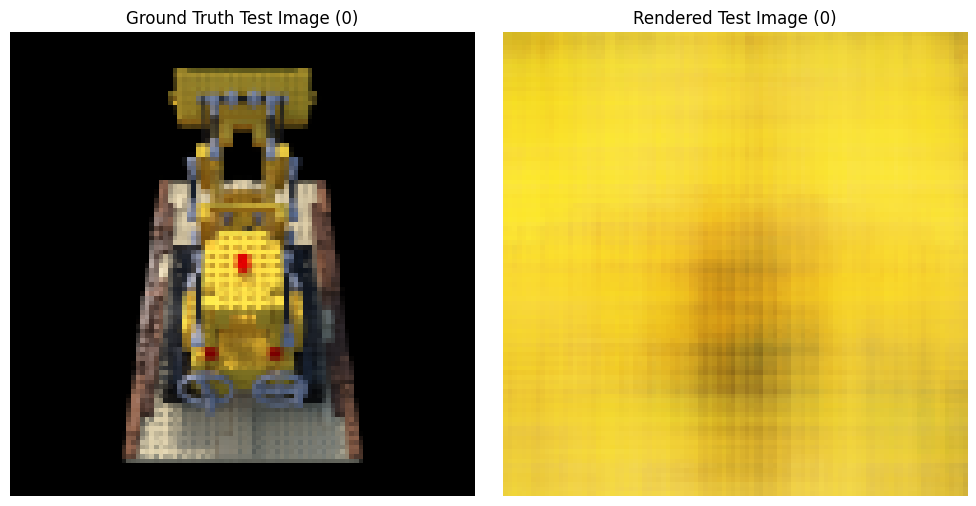

Displaying generated GIF: novel_views_lego_multi_10views_cpu.gif


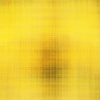

In [42]:
from IPython.display import Image, display
import matplotlib.pyplot as plt # Ensure matplotlib is imported

# --- Display Comparison (if test image was loaded and rendered) ---
if test_target_img is not None and rendered_frames and test_pose is not None:
    # The first rendered frame corresponds to the test pose
    rendered_test_view = rendered_frames[0]
    ground_truth_test_view = (test_target_img.cpu().numpy() * 255).astype(np.uint8)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(ground_truth_test_view)
    axes[0].set_title(f'Ground Truth Test Image ({test_img_idx})')
    axes[0].axis('off')

    axes[1].imshow(rendered_test_view)
    axes[1].set_title(f'Rendered Test Image ({test_img_idx})')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Skipping side-by-side comparison because test image wasn't loaded or rendered.")

# --- Display GIF ---
if os.path.exists(output_gif_path) and rendered_frames:
    print(f"Displaying generated GIF: {output_gif_path}")
    # If the test pose was prepended, the GIF contains it as the first frame.
    # You might want to save/display the GIF excluding the first frame if you only want the novel circular path.
    # Example: iio.imwrite(output_gif_path, rendered_frames[1:], ...)
    display(Image(filename=output_gif_path))
elif not rendered_frames:
    print("Cannot display GIF because no frames were rendered.")
else:
    print(f"Cannot display GIF because it was not found at {output_gif_path}.")